# Supply analysis of Data&Co

 the DataCo company, dataset customer segmentation analysis was performed in this project which helps the company to better understand its customers and target them to increase customer responsiveness and the company's revenue. With a lot of options available to analyze data, it is very difficult to decide which method and machine learning model to use since the performance of the model vary on the parameters available in the data

In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import datetime as dt
import calendar,warnings,itertools,matplotlib,keras,shutil
import tensorflow as tf
import statsmodels.api as sm
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from sklearn.datasets import load_iris,make_regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_ridge import KernelRidge
from keras import Sequential
from keras.layers import Dense
from IPython.core import display as ICD
from lightgbm import LGBMRegressor as lgb

#Hiding the warnings
warnings.filterwarnings('ignore') 

In [3]:
dataset=pd.read_csv("DataCoSupplyChainDataset.csv",header= 0,encoding= 'unicode_escape')
dataset.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


# Data Cleaning

In [4]:


dataset.shape



(180519, 53)

In [5]:


dataset.apply(lambda x: sum(x.isnull())) #Checking missing values



Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0




 since there is a chance different customers might have the same first name or same last name a new column with ‘customer full name’ is created to avoid any ambiguities.


In [6]:


# Adding first name and last name together to create new column
dataset['Customer Full Name'] = dataset['Customer Fname'].astype(str)+dataset['Customer Lname'].astype(str)



To make it easier for analysis some unimportant columns are dropped

In [7]:


data=dataset.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname','Customer Lname',
           'Latitude','Longitude','Product Description','Product Image','Order Zipcode','shipping date (DateOrders)'],axis=1)
data.shape



(180519, 42)

There are 3 missing values in Customer Zipcode column. Since the missing values are just zip codes which are not very important these are replaced with zero before proceeding with data analysis.

In [8]:


data['Customer Zipcode']=data['Customer Zipcode'].fillna(0)#Filling NaN columns with zero



# Data Visualisation

to find important parameters, data correlation is performed

<AxesSubplot:>

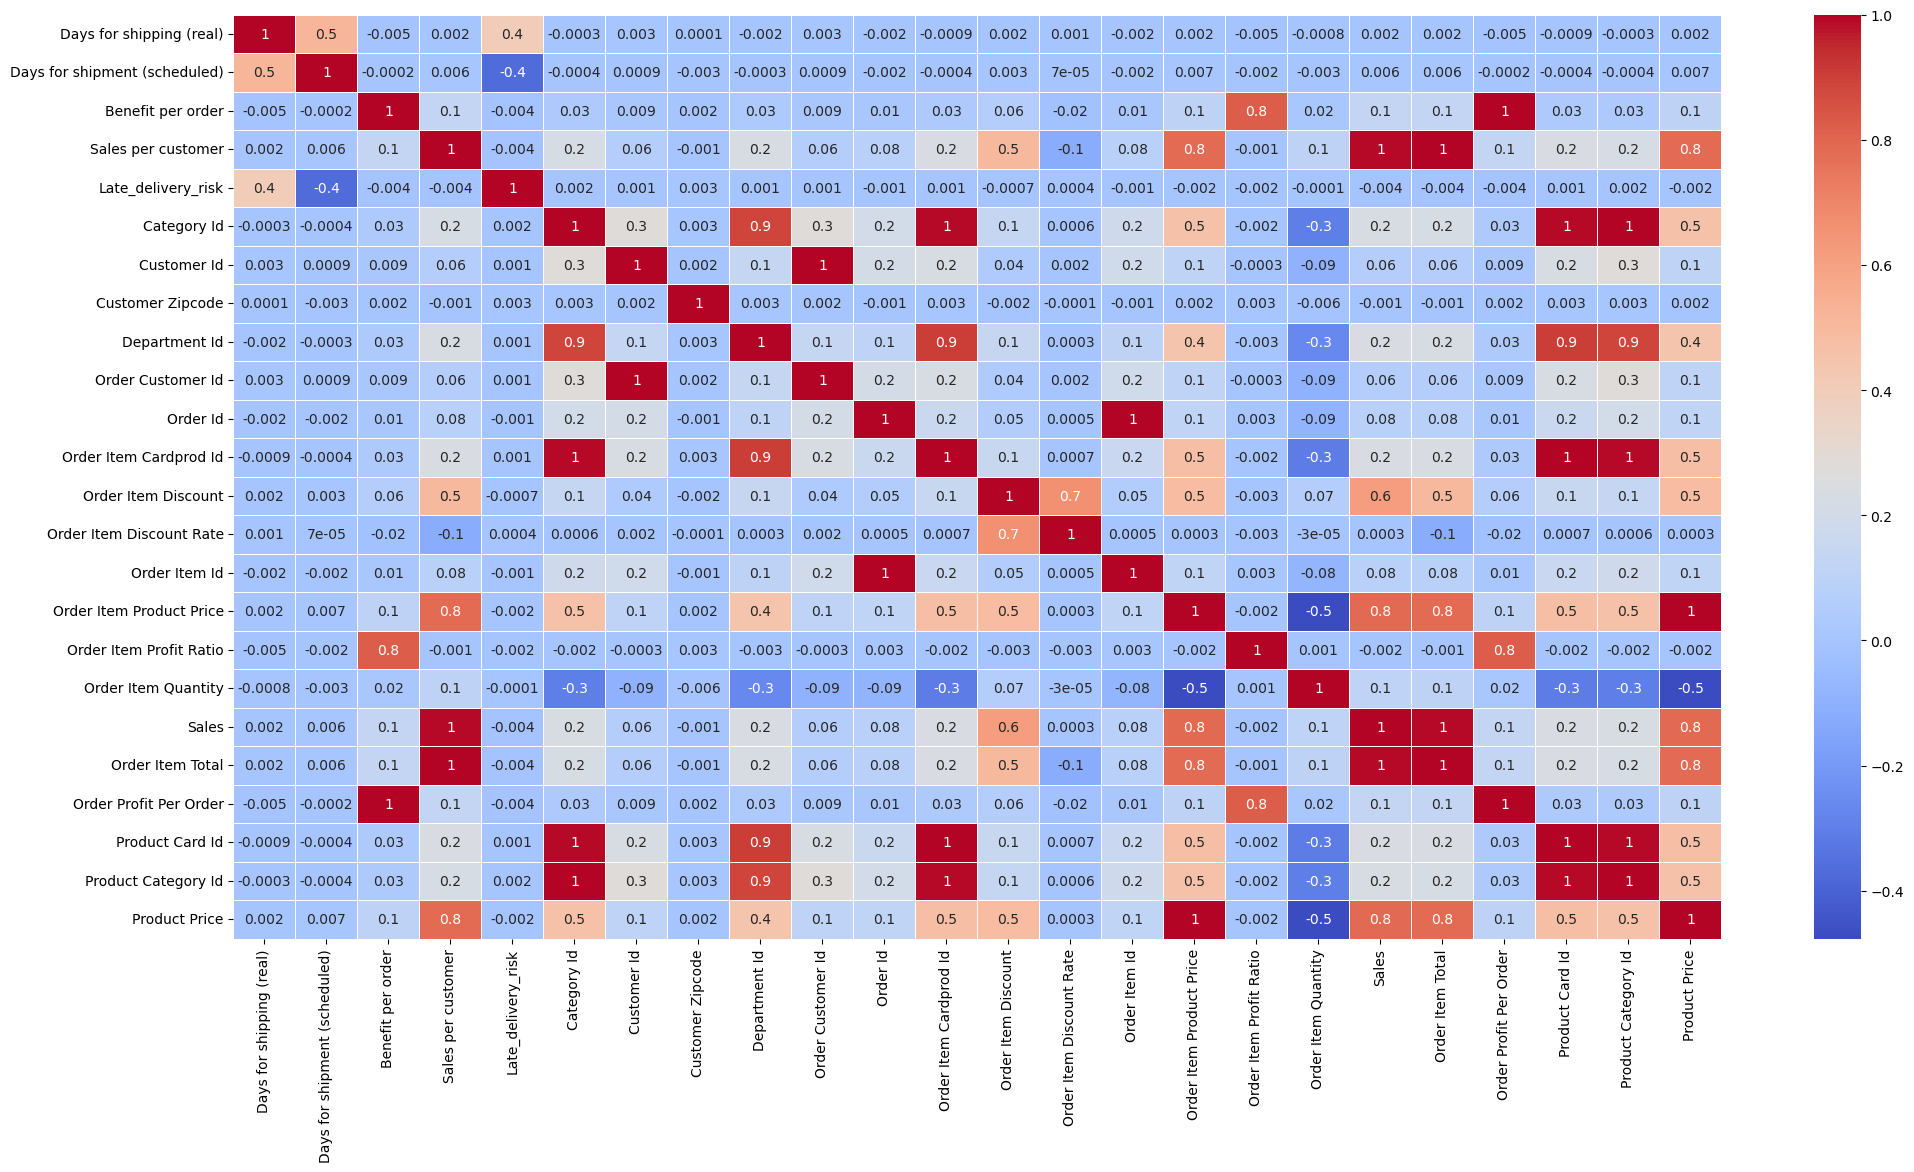

In [9]:


fig, ax = plt.subplots(figsize=(24,12))         # figsize
sns.heatmap(data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm') # Heatmap for correlation matrix



We can observe that product price price has high correlation with Sales,Order Item Total.

As the data which is being used for analysis is related to Supply chain, it makes sense to find which REGION has most sales? 

<AxesSubplot:title={'center':'Total sales for all regions'}, xlabel='Order Region'>

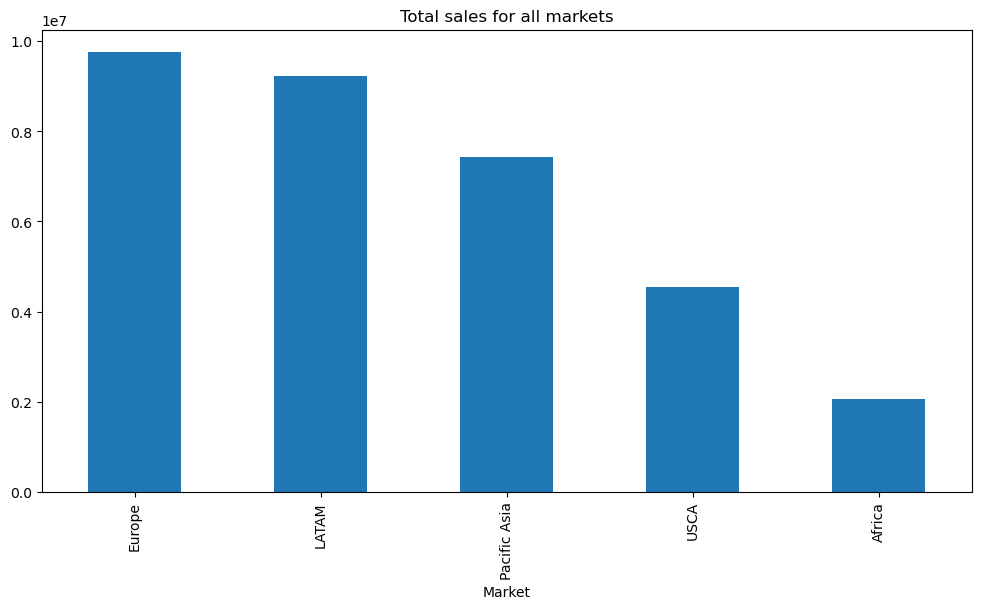

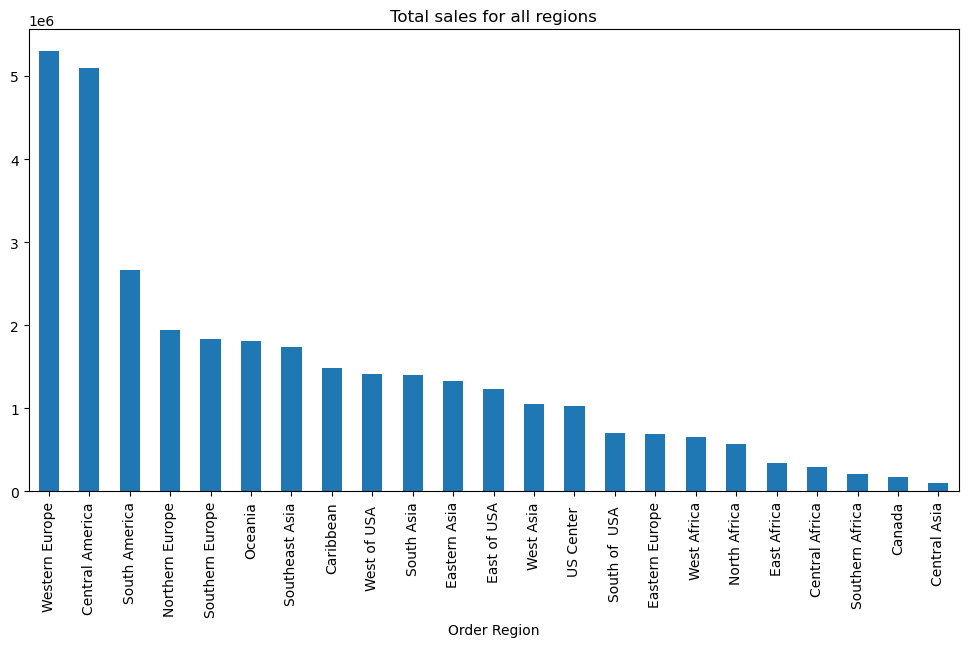

In [10]:
market = data.groupby('Market') #Grouping by market
region = data.groupby('Order Region')
plt.figure(1)
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all markets")
plt.figure(2)
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all regions")



It could be seen from the graph that European market has the most number of sales whereas Africa has the least.In these markets western europe regions and central america recorded highest sales.

Which CATEGORY of products has highest sales?


<AxesSubplot:title={'center':'Average price'}, xlabel='Category Name'>

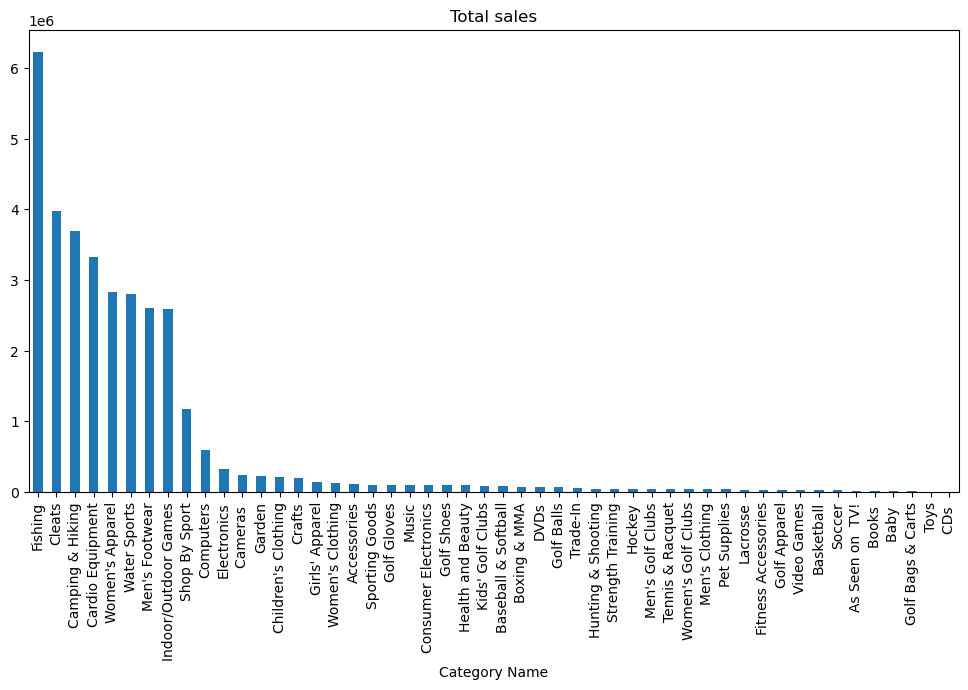

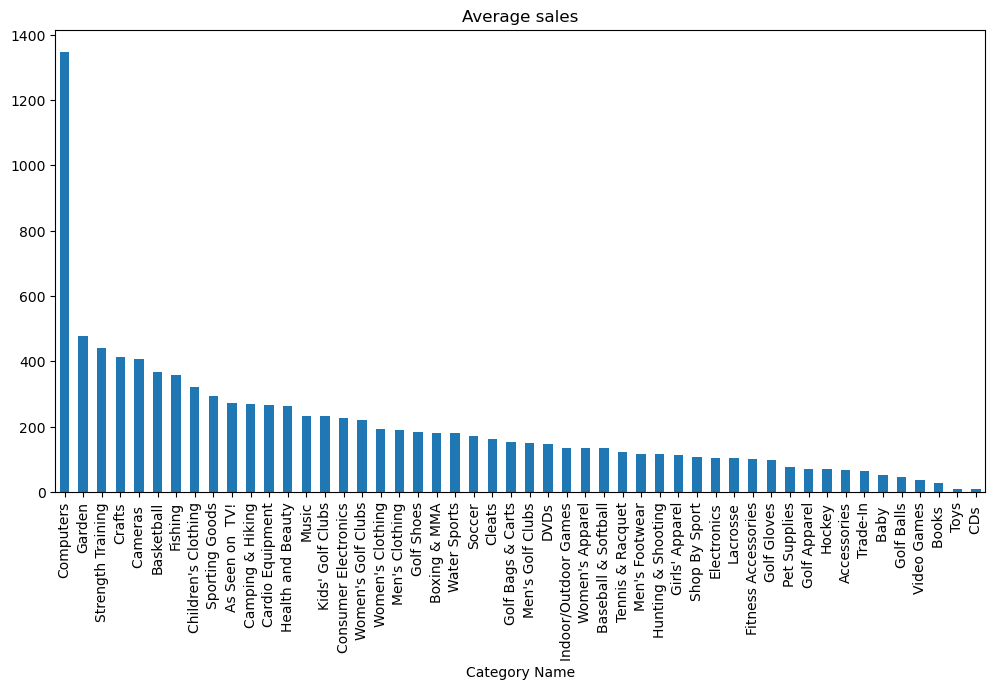

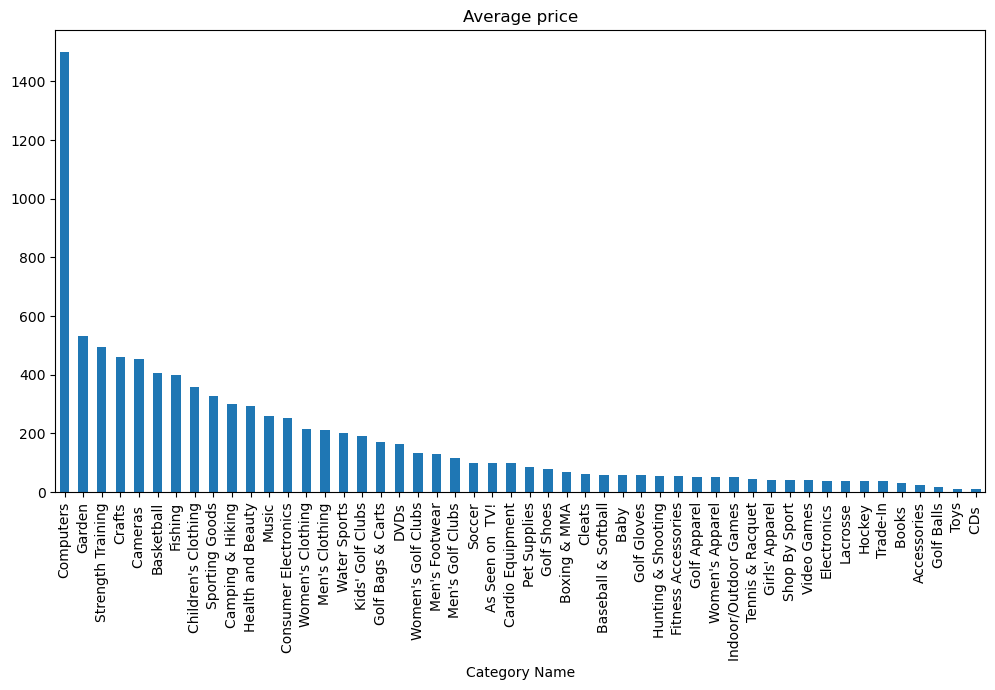

In [11]:
#Grouping all categories
cat = data.groupby('Category Name')
plt.figure(1)
# Total sum of sales for all categories
cat['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales")
# Mean sales for all categories
plt.figure(2)
cat['Sales per customer'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average sales")
plt.figure(3)
# Mean prices for all categories
cat['Product Price'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average price")



As we can see from fig 1 that the fishing category had most number of sales followed by the Cleats.However it is suprising to see that top 7 products with highest price on average are the most sold products on average with computers having almost 1350 sales despite price being 1500$. Since correlation was high between Price and Sales it will be intresting to see how price is impacting the sales for all the products to see the trend.


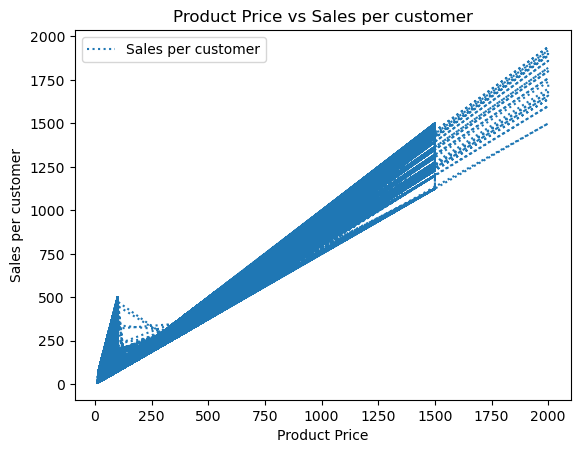

In [12]:
data.plot(x='Product Price', y='Sales per customer',linestyle='dotted',
     markerfacecolor='blue', markersize=12) 
plt.title('Product Price vs Sales per customer')#title
plt.xlabel('Product Price')  # X-axis title
plt.ylabel('Sales per customer') # Y=axis title
plt.show()

 can be observed that prices has linear relation with sales. Which quarter recorded highest sales? It can be found by dividing order time into years,months,week day,hour to better observe the trend.

In [13]:
data['order_year']= pd.DatetimeIndex(data['order date (DateOrders)']).year
data['order_month'] = pd.DatetimeIndex(data['order date (DateOrders)']).month
data['order_week_day'] = pd.DatetimeIndex(data['order date (DateOrders)']).day_name()
data['order_hour'] = pd.DatetimeIndex(data['order date (DateOrders)']).hour
data['order_month_year'] = pd.to_datetime(data['order date (DateOrders)']).dt.to_period('M')

In [ ]:
quater= data.groupby('order_month_year')
quartersales=quater['Sales'].sum().resample('Q').mean().plot(figsize=(15,6))

By seeing above graph it can be seen that sales are consistent from Q1 2015 until Q3 of 2017 and suddenly dipped by Q1 2018. What is the purchase trend in week days,hours and months?

In [ ]:
plt.figure(figsize=(10,12))
plt.subplot(4, 2, 1)
quater= data.groupby('order_year')
quater['Sales'].mean().plot(figsize=(12,12),title='Average sales for 3 years')
plt.subplot(4, 2, 2)
days=data.groupby("order_week_day")
days['Sales'].mean().plot(figsize=(12,12),title='Average sales per week in days')
plt.subplot(4, 2, 3)
hrs=data.groupby("order_hour")
hrs['Sales'].mean().plot(figsize=(12,12),title='Average sales per day in hrs')
plt.subplot(4, 2, 4)
mnth=data.groupby("order_month")
mnth['Sales'].mean().plot(figsize=(12,12),title='Average sales per year in mnths')
plt.tight_layout()
plt.show()


How price is impacting sales, when and which products are having more sales are found.The most number of orders came in October followed by November, and orders for all other months are consistent.Highest number of orders are placed by customers in 2017. Saturday recorded highest number of average sales and wednesday with the least number of sales. The average sales are consistent throughout the day irrespective of time with std of 3.

It is also important to know what type of payment method is being preferred by people to buy all these products in all regions? 


In [ ]:
data['Type'].unique()

Which payment method is preferred the most by people in different regions?

In [ ]:
#xyz = data.groupby('Type')
xyz1 = data[(data['Type'] == 'TRANSFER')]
xyz2= data[(data['Type'] == 'CASH')]
xyz3= data[(data['Type'] == 'PAYMENT')]
xyz4= data[(data['Type'] == 'DEBIT')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Transfer')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='Cash')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='Payment')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='Debit')
plt.xlabel('Order Regions')
plt.ylabel('Number of payments')
plt.title('Different Type of payments used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()



Debit type is most preferred payment method by people in all regions, Cash payment being the least preferred method.

Some products are having negative benefit per orders which indicates that the orders are generating loss of revenue to the company. Which products are these?


In [ ]:
loss = data[(data['Benefit per order']<0)]
#Plotting top 10 products with most loss
plt.figure(1)
loss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Products with most loss")
plt.figure(2)
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Regions with most loss")
#Sum of total sales which are lost
print('Total revenue lost with orders',loss['Benefit per order'].sum())



The total loss sales are approximately 3.9 Millions which is an huge amount.It can be seen that Cleats is the category with most loss sales followed by Mens footwear.Most lost sales are happeing in central america and western europe region.This lost sales may have happened due to suspected frauds or late deliveries.

Finding which payment method is used to conduct frauds can be useful to prevent fraud from happening in future


In [ ]:


#Checking type of payment used to conduct fraud other than Transfer
xyz = data[(data['Type'] != 'TRANSFER')&(data['Order Status'] == 'SUSPECTED_FRAUD')]
xyz['Order Region'].value_counts()





It can be clearly seen that there are no frauds conducted with DEBIT,CASH,PAYMENT methods so all the suspected fraud orders are made using wire transfer probably from abroad. Which region and what product is being suspected to the fraud the most?


In [ ]:
high_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD') & (data['Type'] == 'TRANSFER')]#separating orders with suspected fraud
#Plotting pie chart with respect to order region
fraud=high_fraud['Order Region'].value_counts().plot.pie(figsize=(24,12),
                                                  startangle=180, explode=(0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),autopct='%.1f',shadow=True,)
plt.title("Regions with Highest Fraud",size=15,color='r') # Plotting title
plt.ylabel(" ")
fraud.axis('equal') 
plt.show()



It can be observed that highest number of suspected fraud orders are from Western Europe which is approximately 17.4% of total orders followed by Central America with 15.5%. Which product is being suspected fraud the most?


In [ ]:
high_fraud1 = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] # 
high_fraud2 = data[(data['Order Status'] == 'SUSPECTED_FRAUD') &(data['Order Region'] == 'Western Europe')]
#Plotting bar chart for top 10 most suspected fraud department in all regions
fraud1=high_fraud1['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud Category",color='orange')
#Plotting bar chart for top 10 most suspected fraud department in Western Europe
fraud2=high_fraud2['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud product in Western Europe",color='green')
plt.legend(["All regions", "Western Europe"])
plt.title("Top 10 products with highest fraud detections", size=15)
plt.xlabel("Products", size=13)
plt.ylim(0,600)
plt.show()

It is very suprising to see that cleats department is being suspected to fraud the most followed by Men's footwear in all the regions and also in Western Europe.Which customers are conducting all these fraud?

In [ ]:


#Filtering out suspected fruad orders
cus = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] 
#Top 10 customers with most fraud
cus['Customer Full Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 Highest Fraud Customers")



The customer named Mary Smith alone was responible for trying to conduct fraud 528 times which is very shocking .How much amount exactly did she conduct fraud orders?

In [ ]:


#Filtering orders of mary smith with suspected fraud
amount = data[(data['Customer Full Name'] == 'MarySmith')&(data['Order Status'] == 'SUSPECTED_FRAUD')]
#Plotting bar chart for top 10 most suspected fraud customers
amount['Sales'].sum()



The total amount was almost 102k which is very huge amount.Since Mary was using different address every time when placing orders, a new customer id was issued each time which makes it difficult to identify the customer and ban them. All these parameters should be taken into consideration to improve fraud detection algorithm so fraud can be identified more accurately.

Delivering products to customer on time without late delivery is another important aspect for a supply chain company because customers will not be satisfied if products are not delivered on time. What category of products are being delivered late the most?

In [ ]:
#Filtering columns with late delivery status
late_delivery = data[(data['Delivery Status'] == 'Late delivery')]
#Top 10 products with most late deliveries
late_delivery['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 products with most late deliveries")



It can be seen that orders with Cleats department is getting delayed the most followed by Men's Footwear.For some orders risk of late delivery is given in data.The products with late delivery risk are compared with late delivered products.


In [ ]:
#Filtering orders with late delivery risk
xyz1 = data[(data['Late_delivery_risk'] == 1)]
#Filtering late delivered orders
xyz2 = data[(data['Delivery Status'] == 'Late delivery')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8)) #Figure size
index=np.arange(n_groups)
bar_width=0.2
opacity=0.8
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='r',label='Risk of late delivery')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='y',label='Late delivery')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Late delivered products used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()



Thus,it can be concluded that for all the products with late delivery risk irrespective of region the product is actually being delivered late,to avoid late delivery the company can ship products faster using better shipping method or schedule more time of Days for shipment so customers will know in advance when the products will reach them. It will be interesting to see the number of late deliveried orders for different types of shipment method in all regions.


In [ ]:
#Filtering late delivery orders with standard class shipping
xyz1 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Standard Class')]
#Filtering late delivery orders with first class shipping
xyz2 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'First Class')]
#Filtering late delivery orders with second class shipping
xyz3 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Second Class')]
#Filtering late delivery orders with same day shipping
xyz4 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Same Day')]
#Counting total values
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Standard Class')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='First class')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='second class')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='same day')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Different Types of shipping methods used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

As expected the most number of late deliveries for all regions occured with standard class shipping,with same day shipping being the one with least number of late deliveries.Both the first class and second class shipping have almost equal number of late deliveries.

# Customer Segmentation 

purchase history of customers is already avaialble in the dataset, it can use RFM analysis for customer segmention. Even though there are so many different methods for customer segmentation,RFM analysis is being used because it utilizes numerical values to show Customer recency,frequency and monetary values and also the output results are easy to interpret.

In [ ]:
#Calculating total price for which each order
data['TotalPrice'] = data['Order Item Quantity'] * data['Order Item Total']# Multiplying item price * Order quantity

In [ ]:
data['order date (DateOrders)'].max() # Calculating when the last order come to check recency

In [ ]:
present = dt.datetime(2017,10,9)
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])

In [ ]:
# Grouping all values into new data frame named customer segmentation
Customer_seg = data.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x: (present - x.max()).days, 'Order Id': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})
#Changing order dates to int format
Customer_seg['order date (DateOrders)'] = Customer_seg['order date (DateOrders)'].astype(int)
# Renaming columns as R_Value,F_Value,M_Value
Customer_seg.rename(columns={'order date (DateOrders)': 'R_Value', 
                         'Order Id': 'F_Value', 
                         'TotalPrice': 'M_Value'}, inplace=True)
Customer_seg.head()



R_Value(Recency) indicates how much time elapsed since a customer last order.

F_Value(Frequency) indicates how many times a customer ordered.

M_Value(Monetary value) tells us how much a customer has spent purchasing items.


In [ ]:
plt.figure(figsize=(12,10)) # Figure size
plt.subplot(3, 1, 1)
sns.distplot(Customer_seg['R_Value'])# Plot distribution of R_Value
plt.subplot(3, 1, 2) 
sns.distplot(Customer_seg['F_Value'])# Plot distribution of F_Value
plt.subplot(3, 1, 3)
sns.distplot(Customer_seg['M_Value'])# Plot distribution of M_Value
plt.show()

In [ ]:


quantiles = Customer_seg.quantile(q=[0.25,0.5,0.75]) #Dividing RFM data into four quartiles
quantiles = quantiles.to_dict() 





The total data is divided into 4 quantiles. The R_Value should be low because it indicates recent customer activity and F_value, M_Value should be high since they indicate frequency and total value of purchase. Function is defined to indicate quantiles as numerical values.


In [ ]:
# R_Score should be minimum so 1st quantile is set as 1.
def R_Score(a,b,c):
    if a <= c[b][0.25]:
        return 1
    elif a <= c[b][0.50]:
        return 2
    elif a <= c[b][0.75]: 
        return 3
    else:
        return 4
# The higher the F_Score,M_Score the better so 1st quantile is set as 4.    
def FM_Score(x,y,z):
    if x <= z[y][0.25]:
        return 4
    elif x <= z[y][0.50]:
        return 3
    elif x <= z[y][0.75]: 
        return 2
    else:
        return 1

In [ ]:
# New column for R_Score to indicate numerical score between 1 to 4.
Customer_seg['R_Score'] = Customer_seg['R_Value'].apply(R_Score, args=('R_Value',quantiles))
# New column for F_Score to indicate numerical score between 1 to 4.
Customer_seg['F_Score'] = Customer_seg['F_Value'].apply(FM_Score, args=('F_Value',quantiles))
# New column for M_Score to indicate numerical score between 1 to 4.
Customer_seg['M_Score'] = Customer_seg['M_Value'].apply(FM_Score, args=('M_Value',quantiles))
Customer_seg.head()



The individual scores of R,F,M are known.A column for combined RFM score is created.


In [ ]:
#Adding R,F,M Scores to one new column
Customer_seg['RFM_Score'] = Customer_seg.R_Score.astype(str)+ Customer_seg.F_Score.astype(str) + Customer_seg.M_Score.astype(str)
Customer_seg.head()

How many different customer segments are there in total can be found using .unique() and len method.

In [ ]:


count=Customer_seg['RFM_Score'].unique()
print(count)# Printing all Unique values
len(count)# Total count





It can be seen that there are 33 different customer segments. To make it easier for segmentation individual R,F,M scores are added together


In [ ]:
# Calculate RFM_Score
Customer_seg['RFM_Total_Score'] = Customer_seg[['R_Score','F_Score','M_Score']].sum(axis=1)
Customer_seg['RFM_Total_Score'].unique()



There are 9 values in total for customer segmentation.Appropriate names were assigned for each value seperately.


In [ ]:
# Define rfm_level function
def RFM_Total_Score(df):

    if (df['RFM_Total_Score'] >= 11):# For RFM score with values 11,12
        return 'Champions' 
    elif (df['RFM_Total_Score'] == 10):# For RFM score with value 10
        return 'Loyal Customers' 
    elif (df['RFM_Total_Score'] == 9): # For RFM score with value 9
        return 'Recent Customers'
    elif (df['RFM_Total_Score'] == 8): # For RFM score with value 8
         return 'Promising'
    elif (df['RFM_Total_Score'] == 7): # For RFM score with value 7
        return 'Customers Needing Attention'
    elif (df['RFM_Total_Score'] == 6): # For RFM score with value 6
        return 'Cant lose them'
    elif (df['RFM_Total_Score'] == 5): # For RFM score with value 5
        return 'At Risk'
    else:                               # For RFM score with value less than 5
        
        return 'Lost'
# Create a new variable RFM_Level
Customer_seg['Customer_Segmentation'] =Customer_seg.apply(RFM_Total_Score, axis=1)
# Print the header with top 5 rows to the console
Customer_seg.head()

Plot the different proportion of each customers

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
Customer_seg['Customer_Segmentation'].value_counts().plot.pie(figsize=(10,10),
                                        startangle=135, explode=(0,0,0,0.1,0,0,0,0),autopct='%.1f',shadow=True)
plt.title("Customer Segmentation",size=15)
plt.ylabel(" ")
plt.axis('equal') 
plt.show()

Since total customers are divided into 9 segments it can be seen that, 11.4% customers are at risk of losing them as customers and 11% customers needs attention else even they will be lost eventually.It can be seen that 4.4% of customers are already lost.

Our Top 10 Churned best customers who has not purchased anything in a while

In [ ]:
churned=Customer_seg[(Customer_seg['RFM_Score']=='411')].sort_values('M_Value', ascending=False).head(10)
churned

These customers used to place orders with huge amounts very frequently but they did not place orders from almost a year which means they are purchasing from other companies. These groups of people should be targeted with offers to gain them back.

Top 10 new best customers who place costly orders often

In [ ]:
#The R_Score should be low and F_Score, M_Score should be as high as possible
Customer_seg[(Customer_seg['RFM_Score']=='144')|(Customer_seg['RFM_Score']=='143')].sort_values('M_Value', ascending=False).head(10)

The above customers has the potential to become best customers this people should be targeted to convert them into loyal customers.

### Conclusion
All these different segment of customers should be targeted with different tailored advertisments and rewards for increased profits and more responsiveness from customers.

# Data Modelling

In [ ]:
train_data=data.copy()

Two new columns are created for orders with suspected fraud and late delivery making them into binary classification, which in turn helps to measure performance of different models better.

In [ ]:
train_data['fraud'] = np.where(train_data['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)
train_data['late_delivery']=np.where(train_data['Delivery Status'] == 'Late delivery', 1, 0)

In [ ]:
#Dropping columns with repeated values
train_data.drop(['Delivery Status','Late_delivery_risk','Order Status','order_month_year','order date (DateOrders)'], axis=1, inplace=True)

In [ ]:


train_data.dtypes



 all the object type data is converted to int type using preprocessing label encoder library.

In [ ]:
# create the Labelencoder object
le = preprocessing.LabelEncoder()
#convert the categorical columns into numeric
train_data['Customer Country']  = le.fit_transform(train_data['Customer Country'])
train_data['Market']            = le.fit_transform(train_data['Market'])
train_data['Type']              = le.fit_transform(train_data['Type'])
train_data['Product Name']      = le.fit_transform(train_data['Product Name'])
train_data['Customer Segment']  = le.fit_transform(train_data['Customer Segment'])
train_data['Customer State']    = le.fit_transform(train_data['Customer State'])
train_data['Order Region']      = le.fit_transform(train_data['Order Region'])
train_data['Order City']        = le.fit_transform(train_data['Order City'])
train_data['Category Name']     = le.fit_transform(train_data['Category Name'])
train_data['Customer City']     = le.fit_transform(train_data['Customer City'])
train_data['Department Name']   = le.fit_transform(train_data['Department Name'])
train_data['Order State']       = le.fit_transform(train_data['Order State'])
train_data['Shipping Mode']     = le.fit_transform(train_data['Shipping Mode'])
train_data['order_week_day']    = le.fit_transform(train_data['order_week_day'])
train_data['Order Country']     = le.fit_transform(train_data['Order Country'])
train_data['Customer Full Name']= le.fit_transform(train_data['Customer Full Name'])

#display the initial records
train_data.head()

## Comparision of Classification Models

In [ ]:
#All columns expect fraud
xf=train_data.loc[:, train_data.columns != 'fraud']
#Only fraud column
yf=train_data['fraud']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xf_train, xf_test,yf_train,yf_test = train_test_split(xf,yf,test_size = 0.2,random_state = 42)
#All columns expect fraud
xl=train_data.loc[:, train_data.columns != 'late_delivery']
#Only fraud column
yl=train_data['late_delivery']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xl_train, xl_test,yl_train,yl_test = train_test_split(xl,yl,test_size = 0.2, random_state = 42)

 there are so many different variables with different ranges standard scaler is used to standardize total the data so it is internally consistent before training the data with machine learning.

In [ ]:


sc = StandardScaler()
xf_train=sc.fit_transform(xf_train)
xf_test=sc.transform(xf_test)
xl_train=sc.fit_transform(xl_train)
xl_test=sc.transform(xl_test)



To measure the performance of different models F1 score is used as the main metric because it is the harmonic mean of precison score and recall score.And all the scores are multiplied with 100 for better understanding

In [ ]:
def classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test):
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)  
    accuracy_f=accuracy_score(yf_pred, yf_test) #Accuracy for fraud detection
    accuracy_l=accuracy_score(yl_pred, yl_test) #Accuracy for predection of late delivery
    recall_f=recall_score(yf_pred, yf_test) #Recall score for  fraud detection
    recall_l=recall_score(yl_pred, yl_test)# Recall score for predection of late delivery
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery
    f1_f=f1_score(yf_test, yf_pred)#fraud detection
    f1_l=f1_score(yl_test, yl_pred)#predection of late delivery
    print('Model paramters used are :',model_f)
    print('Accuracy of fraud status is        :', (accuracy_f)*100,'%')
    print('Recall score of fraud status is        :', (recall_f)*100,'%')
    print('Conf Matrix of fraud status is        :\n',  (conf_f))
    print('F1 score of fraud status is        :', (f1_f)*100,'%')
    print('Accuracy of late delivery status is:', (accuracy_l)*100,'%')
    print('Recall score of late delivery status is:', (recall_l)*100,'%')
    print('Conf Matrix of late delivery status is: \n',(conf_l))
    print('F1 score of late delivery status is:', (f1_l)*100,'%')

### Logistic classification model

In [ ]:
model_f = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
model_l = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
#Giving inputs to the defined function
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

### Gaussian naive bayes model

In [ ]:
model_f = GaussianNB()
model_l = GaussianNB()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

### Support vector machines

In [ ]:
model_f = svm.LinearSVC()
model_l = svm.LinearSVC()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

### K nearest Neighbors classification

In [ ]:


model_f = KNeighborsClassifier(n_neighbors=1)
model_l = KNeighborsClassifier(n_neighbors=1)
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)



### Linear Discriminant Analysis

In [ ]:


model_f = LinearDiscriminantAnalysis()
model_l = LinearDiscriminantAnalysis()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)




### Random forest classification

In [ ]:
model_f = RandomForestClassifier()
model_l = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

### Extra trees classification

In [ ]:
model_f = ExtraTreesClassifier(n_estimators=100, max_depth=None,random_state=0)
model_l = ExtraTreesClassifier(n_estimators=100, max_depth=None,random_state=0)
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

### eXtreme Gradient Boosting Classification

In [ ]:
model_f = xgb.XGBClassifier()
model_l = xgb.XGBClassifier()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

### Decision tree classification

In [ ]:
model_f = tree.DecisionTreeClassifier()
model_l = tree.DecisionTreeClassifier()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

 All scores in a dataframe

In [ ]:
#Giving column Values
classification_data = {'Classification Model':  ['Logistic','Gausian Naive bayes','Support Vector Machines','K nearest Neighbour',
                                'Linear Discriminant Analysis','Random Forest','Extra trees','eExtreme gradient boosting','Decision tree'],
        'Accuracy Score for Fraud Detection':     [97.80,87.84,97.75,97.36,97.88,98.48,98.61,98.93,99.12],
        'Recall Score for Fraud Detection':       [59.40,16.23,56.89,41.90,56.57,93.18,98.88,89.89,82.53],
        'F1 Score for Fraud Detection':           [31.22,27.92,28.42,35.67,49.20,54.57,58.60,73.22,81.00],
        'Accuracy Score for Late Delivery':       [98.84,57.27,98.84,80.82,98.37,98.60,99.17,99.24,99.37],
        'Recall Score for Late Delivery':         [97.94,56.20,97.94,83.45,97.68,97.52,98.51,98.65,99.44],
        'F1 Score for Late Delivery':             [98.96,71.95,98.96,82.26,98.52,98.74,99.25,99.31,99.42] }
#Creating data frame with Column Names
classification_comparision = pd.DataFrame (classification_data, columns = ['Classification Model','Accuracy Score for Fraud Detection','Recall Score for Fraud Detection','F1 Score for Fraud Detection',
                                                                           'Accuracy Score for Late Delivery','Recall Score for Late Delivery','F1 Score for Late Delivery'])#Giving column Values
classification_data = {'Classification Model':  ['Logistic','Gausian Naive bayes','Support Vector Machines','K nearest Neighbour',
                                'Linear Discriminant Analysis','Random Forest','Extra trees','eExtreme gradient boosting','Decision tree'],
        'Accuracy Score for Fraud Detection':     [97.80,87.84,97.75,97.36,97.88,98.48,98.61,98.93,99.12],
        'Recall Score for Fraud Detection':       [59.40,16.23,56.89,41.90,56.57,93.18,98.88,89.89,82.53],
        'F1 Score for Fraud Detection':           [31.22,27.92,28.42,35.67,49.20,54.57,58.60,73.22,81.00],
        'Accuracy Score for Late Delivery':       [98.84,57.27,98.84,80.82,98.37,98.60,99.17,99.24,99.37],
        'Recall Score for Late Delivery':         [97.94,56.20,97.94,83.45,97.68,97.52,98.51,98.65,99.44],
        'F1 Score for Late Delivery':             [98.96,71.95,98.96,82.26,98.52,98.74,99.25,99.31,99.42] }
#Creating data frame with Column Names
classification_comparision = pd.DataFrame (classification_data, columns = ['Classification Model','Accuracy Score for Fraud Detection','Recall Score for Fraud Detection','F1 Score for Fraud Detection',
                                                                           'Accuracy Score for Late Delivery','Recall Score for Late Delivery','F1 Score for Late Delivery'])

In [ ]:
classification_comparision.max() #Checking max values in every column

#### Conclusion

Considering F1 score it is clear that Decision Tree classifier is performing better for classification type with F1 score of almost 80% for fraud detection and 99.42% for late delivery.Suprisingly, all the models expect gussian model predicted the late delivery of orders with almost 98% accuracy.Just to make sure that model is predicting correctly the model is cross validated and the results are compared with accuracy of the model.

## Cross validation

In [ ]:
#Defining cross validation model
def cross_validation_model(model_f,model_l,xf,yf,xl,yl):
    model_f= model_f.fit(xf,yf)
    model_l = model_l.fit(xl,yl)
    scores_f = cross_val_score(model_f, xf, yf, cv=6)
    scores_l = cross_val_score(model_l, xl, yl, cv=6)
    print('Model used is',model_f)
    print('Cross validation accuracy of fraud: %0.2f (+/- %0.2f)' % (scores_f.mean(), scores_f.std() * 2))
    print('Cross validation accuracy of late : %0.2f (+/- %0.2f)' % (scores_l.mean(), scores_l.std() * 2))

In [ ]:
cross_validation_model(model_f,model_l,xf,yf,xl,yl)

the difference between cross validated scores and accuracy scores of the model is very minimal it can be confirmed that the data is neither overfitted or underfitted, Which variable was given more importance in the model is found using feature importance method from sklearn.

#### Feature Importance

In [ ]:
important_col=model_f.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':xf.columns[important_col],'importance':model_f.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)



Even though fraud detection is not at all related to Days for shipping(real) it is very surprising to see it was given an importance of 0.12. All other important parameters like customer full name, shipping mode, type of payment used are given an importance of 0.7 which helps the company to detect fraud accurately when same customer is conducting fraud.

Same way which variables were given importance for prediction of late delivery is found.


In [ ]:


important_col=model_l.feature_importances_.argsort()
feat_imp=pd.DataFrame({'features':xl.columns[important_col],'importance':model_l.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='features', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)



It can be seen that the columns for the days of shipping is given almost 90% importance in decision tree model,it will be interesting to see how well the model can predict when these variables are removed.

### Create a new Model , taking the importance of features

In [ ]:
new_data=train_data.copy()

In [ ]:
# Dropping columns in new data set
new_data=new_data.drop(['Days for shipping (real)','Days for shipment (scheduled)'],axis=1)

In [ ]:
#All columns expect fraud
new_xl=new_data.loc[:, new_data.columns != 'late_delivery']
#Only fraud column
new_yl=train_data['late_delivery']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
new_xl_train, new_xl_test,new_yl_train,new_yl_test = train_test_split(new_xl,new_yl,test_size = 0.2,random_state = 42)

standardizing

In [ ]:
new_xl_train=sc.fit_transform(new_xl_train)
new_xl_test=sc.transform(new_xl_test)

Function for classification model is created to train one model

In [ ]:
def New_classifiermodel(model_c,xc_train, xc_test,yc_train,yc_test):
    model_c=model_c.fit(xc_train,yc_train)
    yc_pred=model_c.predict(xc_test) 
    accuracy_c=accuracy_score(yc_pred, yc_test)
    recall_c=recall_score(yc_pred, yc_test,average='weighted')
    conf_c=confusion_matrix(yc_test, yc_pred)
    f1_c=f1_score(yc_test, yc_pred,average='weighted')
    print('Model paramters used are :',model_c)
    print('Accuracy         :', (accuracy_c)*100,'%')
    print('Recall score        :', (recall_c)*100,'%')
    print('Conf Matrix        : \n',(conf_c))
    print('F1 score       :', (f1_c)*100,'%')

Decision Tree classification

In [ ]:
new_model_l=tree.DecisionTreeClassifier()
New_classifiermodel(new_model_l,new_xl_train, new_xl_test,new_yl_train,new_yl_test)

Even when shipping days variables were removed the F1 score and the accuracy of the new model is nearly 84% which is still pretty good. Which variables are given more importance this time?

In [ ]:
important_col=new_model_l.feature_importances_.argsort()
feat_imp=pd.DataFrame({'features':new_xl.columns[important_col],'importance':new_model_l.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='features', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)



This time variables like shipping mode, order city,state are given more importance which helps company to use different shipping methods to deliver products faster.

Since Decision Tree classfier performed better for binary classification it will be interesting to see how well the model performs for multiclassification type data. So model was trained to predict order country.


In [ ]:
#All columns expect order country
xc=train_data.loc[:, train_data.columns != 'Order Country']
#Order column country
yc=train_data['Order Country']
#Splitting 20% of dataset as test data 
xc_train, xc_test,yc_train,yc_test = train_test_split(xc,yc,test_size = 0.2, random_state = 42)

In [ ]:
xc_train=sc.fit_transform(xc_train)
xc_test=sc.transform(xc_test)

#### Decision Tree Multi Classification Mode

In [ ]:


model_c=tree.DecisionTreeClassifier()
New_classifiermodel(model_c,xc_train, xc_test,yc_train,yc_test)



F1 score of almost 100% to predict order country. So it can be concluded that the Decision Tree classifier works best for this dataset for classification type.

# Comparision of Regression Models

For comparison of regression models sales and order quantity are predicted

In [ ]:
xs=train_data.loc[:, train_data.columns != 'Sales']
ys=train_data['Sales']
xs_train, xs_test,ys_train,ys_test = train_test_split(xs,ys,test_size = 0.3, random_state = 42)
xq=train_data.loc[:, train_data.columns != 'Order Item Quantity']
yq=train_data['Order Item Quantity']
xq_train, xq_test,yq_train,yq_test = train_test_split(xq,yq,test_size = 0.3, random_state = 42)

In [ ]:
# Standardize
scaler=MinMaxScaler()
xs_train=scaler.fit_transform(xs_train)
xs_test=scaler.transform(xs_test)
xq_train=scaler.fit_transform(xq_train)
xq_test=scaler.transform(xq_test)

 all the models are compared using mean absolute error (MAE) and RMSE.

The lower the value of mean absolute error the better the model is performing and lower values of RMSE indicate better fit.

In [ ]:
def regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test):
    model_s=model_s.fit(xs_train,ys_train)#Fitting train data for sales
    model_q=model_q.fit(xq_train,yq_train)#Fitting train data for order quantity
    ys_pred=model_s.predict(xs_test)#predicting sales with test data
    yq_pred=model_q.predict(xq_test)#predicting order quantity with test data
    print('Model parameter used are:',model_s) #Printing the model to see which parameters are used
    #Printing mean absolute error for predicting sales
    print("MAE of sales is         :", metrics.mean_absolute_error(ys_test,ys_pred))
    #Printing Root mean squared error for predicting sales
    print("RMSE of sales is        :",np.sqrt(metrics.mean_squared_error(ys_test,ys_pred)))
    #Printing mean absolute error for predicting order quantity
    print("MAE of order quantity   :", metrics.mean_absolute_error(yq_test,yq_pred))
    #Printing Root mean squared error for predicting order quantity
    print("RMSE of order quantity  :",np.sqrt(metrics.mean_squared_error(yq_test,yq_pred)))


Lasso Regression

In [ ]:
model_s = linear_model.Lasso(alpha=0.1)
model_q = linear_model.Lasso(alpha=0.1)
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Ridge Regression

In [ ]:
model_s = Ridge(alpha=1.0)
model_q = Ridge(alpha=1.0)
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)


Light Gradient Boosting Regression

In [ ]:
model_s = lgb.LGBMRegressor()
model_q = lgb.LGBMRegressor()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Random Forest Regression

In [ ]:
model_s = RandomForestRegressor(n_estimators=100,max_depth=10, random_state=40)
model_q = RandomForestRegressor(n_estimators=100,max_depth=10, random_state=40)
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

eXtreme Gradient Boosting Regression

In [ ]:
model_s = xgb.XGBRegressor()
model_q = xgb.XGBRegressor()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Decision Tree Regression

In [ ]:
model_s = tree.DecisionTreeRegressor()
model_q = tree.DecisionTreeRegressor()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Linear Regression

In [ ]:
model_s=LinearRegression()
model_q=LinearRegression()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

For better understanding and comparision of all the scores a dataframe

In [ ]:
#Giving column Values
Regression_data = {'Regression Model':  ['Lasso','Ridge','Light Gradient Boosting','Random Forest',
                                 'eXtreme gradient boosting','Decision tree','Linear Regression'],
        'MAE Value for Sales' :        [1.55,0.75,0.46,0.19,0.154,0.013,0.0005],
        'RMSE Value for Sales':        [2.33,0.97,1.66,1.79,3.13,0.918,0.0014],
        'MAE Value for Quantity' :     [0.90,0.34,0.001,0.0001,0.0005,3.69,0.34],
        'RMSE Value for Quantity':     [1.03,0.52,0.011,0.006,0.004,0.006,0.52] }
#Creating data frame with Column Names
Regression_comparision = pd.DataFrame (Regression_data, columns = ['Regression Model','MAE Value for Sales','RMSE Value for Sales',
        'MAE Value for Quantity','RMSE Value for Quantity'])

#### Comparision Table for Regression Model Scores

In [ ]:
Regression_comparision 

The MAE and RMSE values should be minimum so min function is used to find minimum vales in data frame

In [ ]:


Regression_comparision.min()





Here suprisingly, Linear regression model performed better in comparision to other models followed by decision tree regression model for predicting sales.For predicting order quantity both Random forest and eXtreme gradient boosting did very good.

# Conclusion Analysis of DATA CO COMPAGNY

After analyzing the DataCo Company dataset it has been discovered that both Western Europe and Central America are the regions with the highest number of sales but also the company lost most revenue from these regions only. And both these regions are suspected to the highest number of fraudulent transactions and orders with more late deliveries. The total sales for the company were consistent until the 2017 Quarter 3 and 10% increase in total sales by quarter and then suddenly dipped by almost 65% in 2018 quarter 1. October and November are the months with most sales in the total year. Most people preferred to do payment through debit card and all the fraud transactions are happening with wire transfer so the company should be careful when customers are using wire transfer as the company was scammed with more than 100k by a single customer. All the orders with the risk of late delivery are delivered late every time. Most of the orders with Cleats, Men's Footwear, and Women's Apparel category products are causing late delivery also these products are suspected to fraud the most.A. When compared with other classification machine learning models Decision Tree model did a good job of identifying orders with later delivery and detecting fraudulent transactions with an f1 score of 0.80. For regression type data while the Linear Regression model did better for predicting sales revenue, both Random forest and eXtreme Gradient Boosting Regression predicted the demand more accurately with MAE and RMSE scores lower . A. For further study, all the machine learning models can be compared with different datasets to confirm wheter the same machine learning models are performing better or not.And the performance of these machine learning models can be improved with hyper parameter tuning.
